In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Useful functions

In [19]:
def random_Split_data(data: pd.DataFrame, rate = 0.75, random_seed: int = -1):
    m, n = data.shape
    if random_seed != -1:
        np.random.seed(abs(random_seed))
    _data = data.reindex(np.random.permutation(data.index)).copy()

    row_split = int(m * rate)
    X_train = _data.iloc[0: row_split, 0: n - 1].values
    y_train = _data.iloc[0: row_split, n - 1: ].values
    X_test = _data.iloc[row_split: m, 0: n - 1].values
    y_test = _data.iloc[row_split: m, n - 1: ].values
    
    return X_train, y_train, X_test, y_test


def show(times, loss, color = '#4169E1', start=0, end=1500):
    x_axis_data = list(range(times))[start:end]
    y_axis_data = loss[start:end]
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)

In [20]:
RED = '#FF0000'
PINK = '#FF1493'
PURPLE = '#A020F0'
ORANGE = '#FF7F00'
TOMATO = '#EE5C42'
BLUE = '#0000FF'
SKY = '#00BFFF'
GREEN = '#00FF00'
LIGHTGREEN = '#90EE90' 
BLACK = '#000000'
YELLOW = '#FFFF00'
color_list = [RED, BLUE, GREEN, SKY, LIGHTGREEN, ORANGE, BLACK]


## Model: Regression tree

In [21]:
class Node:
    def __init__(self, index:list, id = -1, feature = -1, f_val = -1.) -> None:
        
        self.l = -1
        self.r = -1
        self.id = id
        self.w = -1
        
        self.index = index
        self.feature = feature
        self.f_val = f_val
        


class RegTree(object):
    def __init__(self, X:np.ndarray, y:np.ndarray, y_t:np.ndarray):
        # Initialize the regression tree
        self.X = X
        self.y = y
        self.m, self.n = X.shape
        
        self.g = 2 * (y_t - y)
        
        self.leaf_num = 0
        self.node_num = 0
        self.depth = 0
    
        self.err_list = []
        self.RMSE_list = []
    

    def _get_best_split(self, node:Node):
        # Get the best feature and split
        m = len(node.index)
        gain = -1
        feature = []
        feature_list = []
        
        max_gain = 0
        max_feature = -1
        max_f_value = -1
        
        max_index1 = []
        max_index2 = []
              
        for col in range(self.n):
            _feature = self.X[node.index, col:col+1].copy().reshape(1, -1)[0]

            feature = list(set(_feature))
            feature.sort()
            
            for f_value in feature:
                _index1 = np.where((self.X[node.index, col:col+1] <= f_value).all(axis=1))[0]
                index1 = np.array(node.index)[_index1]
                _index2 = np.where((self.X[node.index, col:col+1] > f_value).all(axis=1))[0]
                index2 = np.array(node.index)[_index2]
                gain = self._get_score(node.index, self.leaf_num) - self._get_score(index1, self.leaf_num + 1) - self._get_score(index2, self.leaf_num + 1)

                if gain > max_gain:
                    max_gain = gain
                    max_feature = col
                    max_f_value = f_value
                    max_index1 = index1
                    max_index2 = index2
                
        return max_feature, max_f_value, max_gain, max_index1, max_index2
                
            

    def _get_score(self, index:np.ndarray, T):
        # Get the objective function value of a partition  
        g = self.g[index, :].sum()
        score = (-0.5*g**2)/(2*len(index) + self.lamda) + self.gamma * T
        return score
    
    
    def _get_err(self, pre: np.ndarray):
        y = pre - self.y
        return (y.T @ y)[0][0]
    
    
    def _fit(self, node:Node, depth = 1)->int:
        cur_pre = self.predict(self.X)
        self.RMSE_list.append(self.RMSE(cur_pre, self.y))
        self.err_list.append(self._get_err(cur_pre))
        
        feature, f_value, gain, index1, index2 = self._get_best_split(node)
        
        _feature = self.X[node.index, feature:feature+1].copy().reshape(1, -1)[0]
        f = list(set(_feature))
        
        if len(node.index) <= self.min_samples or len(f) <= self.min_feature_dif or depth >= self.max_depth or gain <= self.gain_delta:
            # This is a leaf
            
            new_w = -self.g[node.index, :].sum()/(2*len(node.index) + self.lamda)
            node.w = new_w
            self.leaf_num += 1
            
            if (self.if_silent == 0):
                print(depth, new_w)
                if len(node.index) <= self.min_samples:
                    print("stop reason: no enough samples")
                elif len(f) <= self.min_feature_dif:
                    print("stop reason: no enough feature values")
                elif depth >= self.max_depth:
                    print("stop reason: depth reaches limit")
                elif gain <= self.gain_delta:
                    print("stop reason: gain less than [gain_delta]")
                
            return depth
        
        node.feature = feature
        node.f_val = f_value
        node.l = Node(index1, id=self.node_num)
        node.r = Node(index2, id=self.node_num + 1)
        self.node_num += 2

        return max(self._fit(node.l, depth+1), self._fit(node.r, depth+1))
        
        
    def _set_parameters(self, default_parameters: dict):
        self.lamda = default_parameters['lamda']
        self.gamma = default_parameters['gamma']
        self.gain_delta = default_parameters['gain_delta']
        self.max_depth = default_parameters['max_depth']
        self.min_samples = default_parameters['min_samples']
        self.min_feature_dif = default_parameters['min_feature_dif']
        self.if_silent = default_parameters['if_silent']
        
    
    def fit(self, parameters: dict = {}):
        # Train a regression tree 
        default_parameters = {
            "lamda": 2,             # Hyperparameters
            "gamma": 1e-6,          # Hyperparameters
            "gain_delta": 0,        # The minimum gain
            "max_depth": 7,
            "max_leaves": 100,
            "max_nodes": 1000,
            "min_samples": 10,      # Minimum number of samples on a leaf
            "min_feature_dif": 5,   # The minimum number of different value for current feature
            "if_silent": 1
        }
        
        for key in parameters.keys():
            if default_parameters.__contains__(key):
                default_parameters[key] = parameters[key]
        self._set_parameters(default_parameters)
        
        index = np.arange(self.m)
        node = Node(index, 0)
        self.root = node
        self.node_num = 1
        self.depth = self._fit(node)
                
    
    def _predict(self, x:np.ndarray): 
        # Predict a sample
        node = self.root
        while node.l != -1 or node.r != -1:
            if x[0][node.feature] <= node.f_val:       
                node = node.l
            else:
                node = node.r
        return node.w
        

    def predict(self, X:np.ndarray): 
        # Predict multiple samples
        m, _ = X.shape
        pre = []
        for i in range(m):
            prei = self._predict(X[i].reshape(1, -1))
            pre.append(prei)
        
        return np.array(pre).reshape(m, 1)
    
    
    def RMSE(self, pre:np.ndarray, val:np.ndarray):
        y = val - pre
        m, _ = y.shape
        return np.sqrt((y.T @ y) / m)[0][0]
    
    def R2(self, pre:np.ndarray, val:np.ndarray):
        var = np.var(val)
        return(1 - (self.RMSE(pre, val) ** 2)/ var)
    

## Model: XGBoost

In [22]:
class XGBoost(object):
    
    def __init__(self, X_train:np.ndarray, y_train:np.ndarray) -> None:
        self.X = X_train
        self.y = y_train
        self.m, self.n = self.X.shape
        self.treeset = []
        self.train_err = []

    def fit(self, T = 10, min_train_err = 1e-6, tree_parameters: dict = {}):
        m, n = self.y.shape
        self.T = T
        y_t = np.zeros((m, 1))
        
        for _ in range(0, self.T):
            tree = RegTree(self.X, self.y, y_t)
            tree.fit(tree_parameters)
            
            y_t = y_t + tree.predict(self.X)
            self.treeset.append(tree)
            err = tree._get_err(y_t)
            self.train_err.append(err)
            if err < min_train_err:
                break
    
    
    def predict(self, X_test:np.ndarray):
        m, n = X_test.shape
        pre = np.zeros((m, 1))
        for tree in self.treeset:
            pre = pre + tree.predict(X_test)
        return pre
    
    
    def RMSE(self, pre:np.ndarray, val:np.ndarray):
        y = val - pre
        m, _ = y.shape
        return np.sqrt((y.T @ y) / m)[0][0]
    
    def R2(self, pre:np.ndarray, val:np.ndarray):
        var = np.var(val)
        return(1 - (self.RMSE(pre, val) ** 2)/ var)
    

## Train and test
### Regression Tree

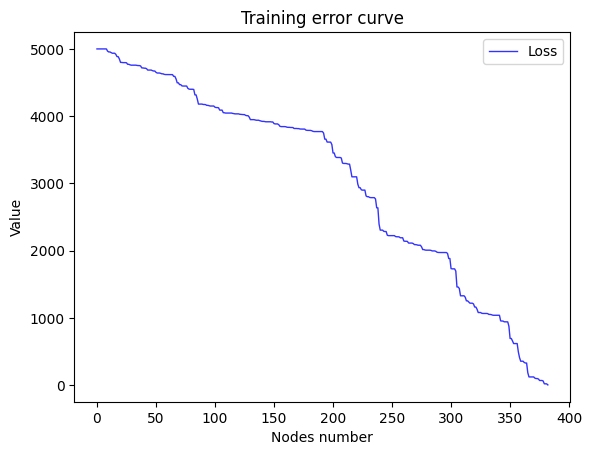

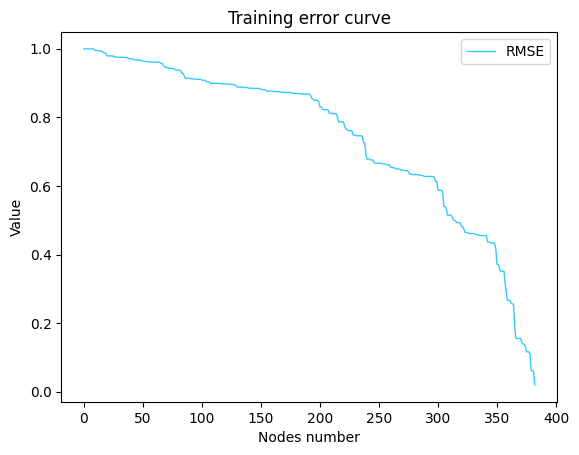

192 9
RMSE = 0.00020977250272198462
R2 = 0.7441905477663242


In [24]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))


parameters = {
    "lamda": 0.1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 9,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 5,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}

tree = RegTree(X_train, y_train, y_t)

tree.fit(parameters)

pre = tree.predict(X_test)
times = tree.node_num
show(times, tree.err_list, color=BLUE)
plt.legend(['Loss'], loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('Value')
plt.title('Training error curve')
plt.show()
show(times, tree.RMSE_list, color=SKY)
plt.legend(['RMSE'], loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('Value')
plt.title('Training error curve')
plt.show()

print(tree.leaf_num, tree.depth)
print("RMSE = {}".format(tree.RMSE(pre, y_test)))
print("R2 = {}".format(tree.R2(pre, y_test)))

### XGBoost

RMSE = 0.00018284918922737087
R2 = 0.8073662903510819
Sklearn R2 = 0.8404273489905976


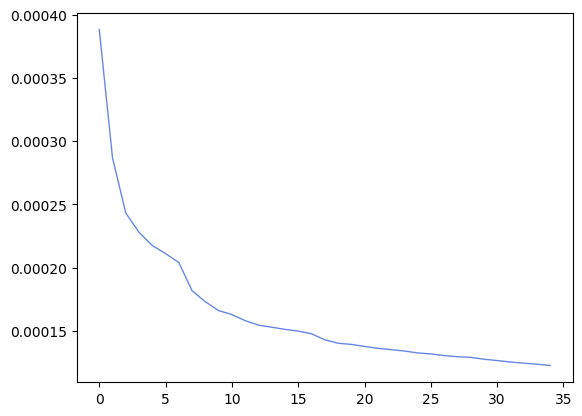

In [392]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

boost = XGBoost(X_train, y_train)
tree_parameters = {
    "lamda": 1,         
    "gamma": 0,          
    "gain_delta": 0,     
    "max_depth": 3,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3,  
    "if_silent": 1,
}
boost.fit(T=35, tree_parameters=tree_parameters, min_train_err=1e-4)
pre = boost.predict(X_test)

print("RMSE = {}".format(boost.RMSE(pre, y_test)))
print("R2 = {}".format(boost.R2(pre, y_test)))

times = len(boost.train_err)
show(times, boost.train_err)

import sklearn.ensemble as ens
ens_model = ens.GradientBoostingRegressor()
ens_model.fit(X_train, y_train.flatten())
print("Sklearn R2 = {}".format(ens_model.score(X_test, y_test)))


## Parameter adjustment and comparison
### Regression Tree

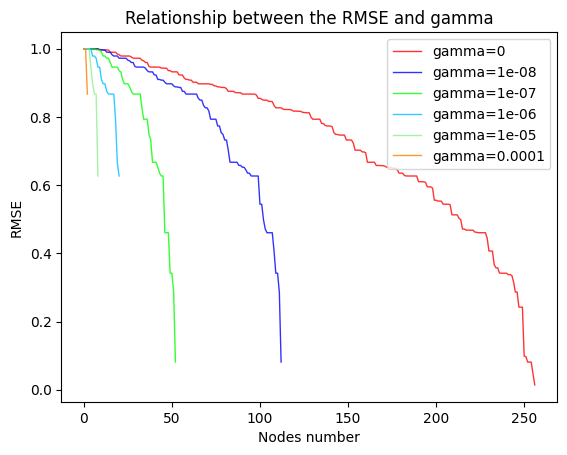

In [378]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

parameters = {
    "lamda": 1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 10,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}
val_list = [0, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    parameters['gamma'] = val
    tree = RegTree(X_train, y_train, y_t)
    tree.fit(parameters)
    pre = tree.predict(X_test)
    times = tree.node_num
    show(times, tree.err_list, color=color_list[i])
    tag_list.append('gamma=' + str(val))


plt.legend(tag_list, loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('RMSE')
plt.title('Relationship between the RMSE and gamma')
plt.show()

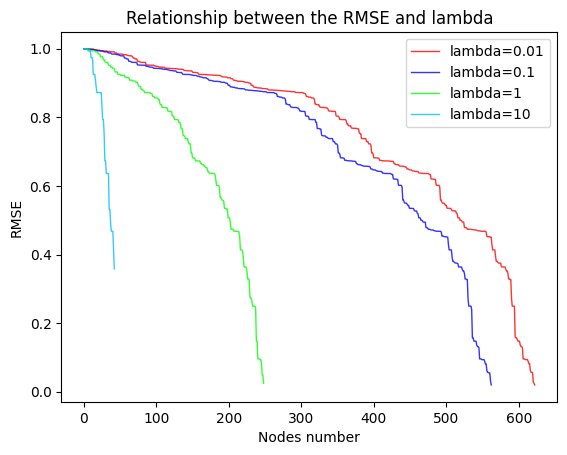

In [379]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

parameters = {
    "lamda": 1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 10,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}
val_list = [0.01, 0.1, 1, 10]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    parameters['lamda'] = val
    tree = RegTree(X_train, y_train, y_t)
    tree.fit(parameters)
    pre = tree.predict(X_test)
    times = tree.node_num
    show(times, tree.err_list, color=color_list[i])
    tag_list.append('lambda=' + str(val))


plt.legend(tag_list, loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('RMSE')
plt.title('Relationship between the RMSE and lambda')
plt.show()

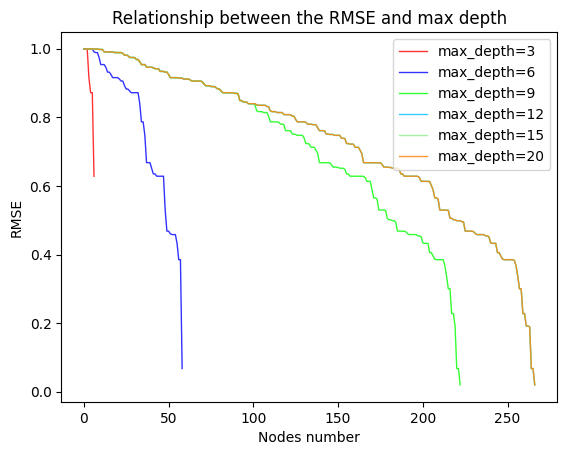

In [380]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

parameters = {
    "lamda": 1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 10,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}
val_list = [3, 6, 9, 12, 15, 20]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    parameters['max_depth'] = val
    tree = RegTree(X_train, y_train, y_t)
    tree.fit(parameters)
    pre = tree.predict(X_test)
    times = tree.node_num
    show(times, tree.err_list, color=color_list[i])
    tag_list.append('max_depth=' + str(val))


plt.legend(tag_list, loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('RMSE')
plt.title('Relationship between the RMSE and max depth')
plt.show()

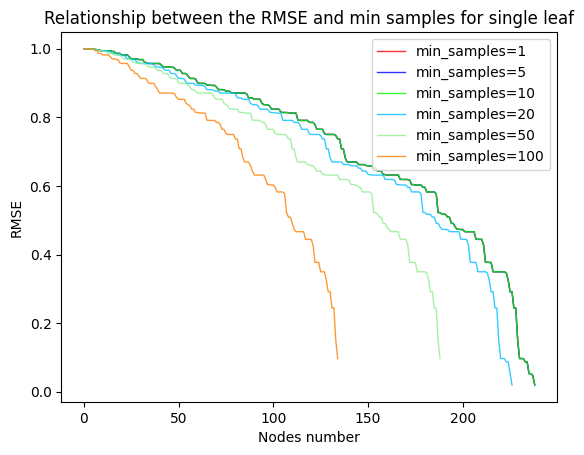

In [381]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

parameters = {
    "lamda": 1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 10,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}
val_list = [1, 5, 10, 20, 50, 100]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    parameters['min_samples'] = val
    tree = RegTree(X_train, y_train, y_t)
    tree.fit(parameters)
    pre = tree.predict(X_test)
    times = tree.node_num
    show(times, tree.err_list, color=color_list[i])
    tag_list.append('min_samples=' + str(val))


plt.legend(tag_list, loc='upper right')
plt.xlabel('Nodes number')
plt.ylabel('RMSE')
plt.title('Relationship between the RMSE and min samples for single leaf')
plt.show()

### XGBoost

In [388]:
parameters = {
    "lamda": 0.1,            
    "gamma": 0,            
    "gain_delta": 0,       
    "max_depth": 3,
    "max_leaves": 100,
    "max_nodes": 1000,
    "min_samples": 3,      
    "min_feature_dif": 3, 
    "if_silent": 1,
}

In [391]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

val_list = [5, 15, 30, 50]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    boost = XGBoost(X_train, y_train)
    boost.fit(T=val, tree_parameters=parameters, min_train_err=1e-5)
    pre = boost.predict(X_test)

    print("Tree_num = {}:".format(val))
    print("RMSE = {}".format(boost.RMSE(pre, y_test)))
    print("R2 = {}".format(boost.R2(pre, y_test)))


Tree_num = 5:
RMSE = 0.0002228821224647469
R2 = 0.7056472568446303
Tree_num = 15:
RMSE = 0.00020231828039610049
R2 = 0.7574574897980364
Tree_num = 30:
RMSE = 0.00019500638922750183
R2 = 0.7746719285362886
Tree_num = 50:
RMSE = 0.00018936085993332026
R2 = 0.7875297875290224


In [390]:
df = pd.read_csv('train.data.txt',header=None)
X_train, y_train, X_test, y_test = random_Split_data(df, rate=0.7)
m, n = y_train.shape
y_t = np.zeros((m, n))

val_list = [1e-2, 1e-4, 1e-6, 1e-8]
tag_list = []

for i in range(0, len(val_list)):
    val = val_list[i]
    boost = XGBoost(X_train, y_train)
    boost.fit(T=30, tree_parameters=parameters, min_train_err=val)
    pre = boost.predict(X_test)
    
    print("min_train_err = {}:".format(val))
    print("RMSE = {}".format(boost.RMSE(pre, y_test)))
    print("R2 = {}".format(boost.R2(pre, y_test)))


min_train_err = 0.01:
RMSE = 0.00028043423749604446
R2 = 0.5290215484786978
min_train_err = 0.0001:
RMSE = 0.0001909678403234142
R2 = 0.7815965763957533
min_train_err = 1e-06:
RMSE = 0.0001909678403234142
R2 = 0.7815965763957533
min_train_err = 1e-08:
RMSE = 0.0001909678403234142
R2 = 0.7815965763957533
